In [1]:
# from google.colab import drive
# drive.mount('/content/drive/')

In [2]:
SIZE = 256
EPOCH = 200
BATCH_SIZE = 16
test_ratio = 0.2
INPUT_SHAPE = (SIZE, SIZE, 3) 
MODEL_NAME = 'custom_1.h5'
TB_FILE = 'custom_1'

In [3]:
from keras.callbacks import TensorBoard
tensorboard = TensorBoard(log_dir="logs\\{}".format(TB_FILE))

In [4]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from keras.utils import np_utils
plt.style.use('classic')

from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization, AvgPool2D
from keras.layers import Activation, Dropout, Flatten, Dense

import os
import cv2
from PIL import Image
import numpy as np

In [5]:
# load train data

image_directory = '/content/drive/MyDrive/Dataset/train/'
# image_directory = 'archive/train/'
dataset = []
label = [] 

badimgs = os.listdir(image_directory + 'not-good/')
for i, image_name in enumerate(badimgs):   
    if (image_name.split('.')[1] == 'png'):
        image = cv2.imread(image_directory + 'not-good/' + image_name)
        image = cv2.resize(image , (SIZE, SIZE))
        image = image/255.0
        dataset.append(image)
        label.append(1)


goodimgs = os.listdir(image_directory + 'good/')
for i, image_name in enumerate(goodimgs):
    if (image_name.split('.')[1] == 'png'):
        image = cv2.imread(image_directory + 'good/' + image_name)
        image = cv2.resize(image , (SIZE, SIZE))
        image = image/255.0
        dataset.append(image)
        label.append(0)


dataset = np.array(dataset)
label = np.array(label)

print(dataset.shape)
print(label.shape)

(300, 256, 256, 3)
(300,)


In [6]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(dataset, label, test_size = test_ratio, random_state = 0) 

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test)

(240, 256, 256, 3)
(240,)
(60, 256, 256, 3)
[0 0 1 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0
 0 0 1 0 0 0 1 0 0 0 0 1 1 0 0 0 0 0 0 0 1 0 0]


In [7]:
# oversampling
from imblearn.combine import SMOTETomek
from imblearn.over_sampling import RandomOverSampler

# Create an oversampler
# smk = SMOTETomek(random_state=42)
ovs = RandomOverSampler(random_state=0)

dataset2d = X_train.reshape(X_train.shape[0], -1)

# Fit and transform the data
dataset1, y_train = ovs.fit_resample(dataset2d, y_train)
X_train = dataset1.reshape(dataset1.shape[0], SIZE, SIZE, 3)

print(X_train.shape)
print(y_train.shape)
# print(y_train)

(398, 256, 256, 3)
(398,)


In [8]:
# data augmentation
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(rotation_range=360)
datagen.fit(X_train)

In [9]:
# import tensorflow as tf

# base_model = tf.keras.applications.mobilenet_v2.MobileNetV2(
#     weights='imagenet',
#     include_top=False,
#     pooling='avg'
# )

# # base_model = tf.keras.applications.ResNet50(
# #     weights='imagenet',
# #     include_top=False,
# #     pooling='avg'
# # )

# base_model.trainable = False 

# model = tf.keras.Sequential([
#     base_model,
#     tf.keras.layers.Dense(512, activation='relu'), 
#     # tf.keras.layers.Dropout(0.5),
#     tf.keras.layers.Dense(128, activation='relu'),        
#     tf.keras.layers.Dense(1, activation='sigmoid')
# ])


# model.summary()

In [31]:
import tensorflow as tf

model = Sequential()
model.add(Conv2D(16, (4, 4), input_shape=INPUT_SHAPE))
model.add(Activation('relu'))
# model.add(AvgPool2D(pool_size=(2, 2)))

model.add(Conv2D(16, (3, 3)))
model.add(Activation('relu'))
# model.add(AvgPool2D(pool_size=(2, 2)))

model.add(Conv2D(16, (2, 2)))
model.add(Activation('relu'))
# model.add(AvgPool2D(pool_size=(2, 2)))

model.add(Conv2D(16, (2, 2)))
model.add(Activation('relu'))

model.add(Flatten())
# model.add(Dense(128, kernel_regularizer=tf.keras.regularizers.l2(0.01)))
# model.add(Activation('relu'))

# model.add(Dropout(0.5))

model.add(Dense(1))
model.add(Activation('sigmoid'))  


In [32]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [33]:
history = model.fit(datagen.flow(X_train, y_train, batch_size=BATCH_SIZE),
                    steps_per_epoch=len(X_train) / BATCH_SIZE,
                    epochs=EPOCH,
                    validation_data=(X_test, y_test),
                    callbacks=[tensorboard],
                    )


model.save(MODEL_NAME)

train_score = model.evaluate(X_train, y_train, verbose=0)
test_score = model.evaluate(X_test, y_test, verbose=0)
print('Train Loss:{0:.3f}'.format(train_score[0]))
print('Train accuracy:{0:.3}'.format(train_score[1]))
print('Test Loss:{0:.3f}'.format(test_score[0]))
print('Test accuracy:{0:.3}'.format(test_score[1]))

Epoch 1/200
24/24 [==============================] - 10s 302ms/step - loss: 0.9318 - accuracy: 0.4899 - val_loss: 0.7113 - val_accuracy: 0.4500
Epoch 2/200
24/24 [==============================] - 5s 214ms/step - loss: 0.7111 - accuracy: 0.5276 - val_loss: 0.4585 - val_accuracy: 0.8500
Epoch 3/200
24/24 [==============================] - 5s 214ms/step - loss: 0.7277 - accuracy: 0.5025 - val_loss: 0.5304 - val_accuracy: 0.8500
Epoch 4/200
24/24 [==============================] - 7s 269ms/step - loss: 0.7203 - accuracy: 0.5452 - val_loss: 0.6572 - val_accuracy: 0.8500
Epoch 5/200
24/24 [==============================] - 5s 207ms/step - loss: 0.7002 - accuracy: 0.5276 - val_loss: 0.5721 - val_accuracy: 0.8500
Epoch 6/200
24/24 [==============================] - 6s 229ms/step - loss: 0.7047 - accuracy: 0.5176 - val_loss: 0.8135 - val_accuracy: 0.1500
Epoch 7/200
24/24 [==============================] - 5s 210ms/step - loss: 0.6995 - accuracy: 0.5025 - val_loss: 0.7443 - val_accuracy: 0.150

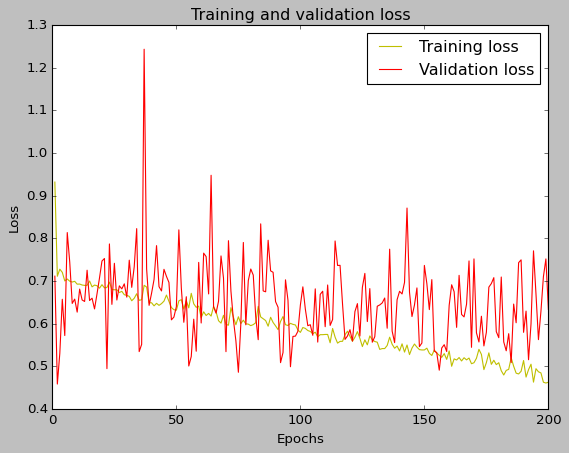

In [34]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

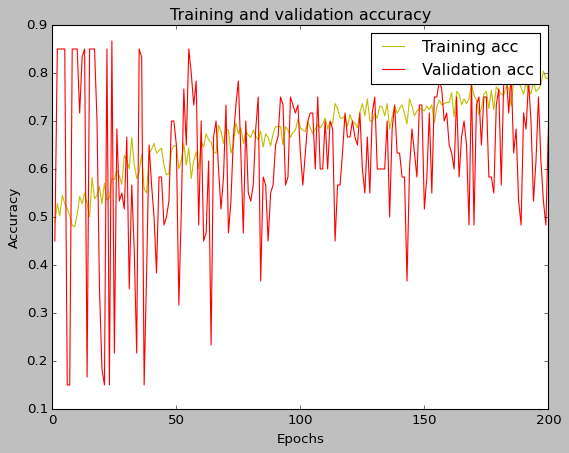

In [35]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [36]:
# calculate precision and recall
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, confusion_matrix

y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5)

print('Accuracy: {:.2f}'.format(accuracy_score(y_test, y_pred)))
print('Precision: {:.2f}'.format(precision_score(y_test, y_pred)))
print('Recall: {:.2f}'.format(recall_score(y_test, y_pred)))
print('F1: {:.2f}'.format(f1_score(y_test, y_pred)))
print('ROC AUC: {:.2f}'.format(roc_auc_score(y_test, y_pred)))
print('Confusion Matrix: ', confusion_matrix(y_test, y_pred))

2/2 [==============================] - 0s 29ms/step
Accuracy: 0.68
Precision: 0.08
Recall: 0.11
F1: 0.10
ROC AUC: 0.45
Confusion Matrix:  [[40 11]
 [ 8  1]]


In [37]:
mythreshold=0.5
from sklearn.metrics import confusion_matrix

y_pred = (model.predict(X_test)>= mythreshold).astype(int)
cm=confusion_matrix(y_test, y_pred)  
print(cm)

y_pred = (model.predict(dataset)>= mythreshold).astype(int)
cm=confusion_matrix(label, y_pred)  
print(cm)

2/2 [==============================] - 0s 28ms/step
[[40 11]
 [ 8  1]]
10/10 [==============================] - 1s 63ms/step
[[210  40]
 [ 22  28]]


In [38]:
# test_image_directory = 'archive/'
test_image_directory = '/content/drive/MyDrive/Dataset/'
test_dataset = []

testimg = os.listdir(test_image_directory + 'test/')
for i, image_name in enumerate(testimg):   
    if (image_name.split('.')[1] == 'png'):
        image = cv2.imread(test_image_directory + 'test/' + image_name)
        image = cv2.resize(image , (SIZE, SIZE))
        image = image/255.0
        test_dataset.append(image)

test_dataset = np.array(test_dataset)

In [40]:
from sklearn.metrics import roc_curve
y_preds = model.predict(X_test).ravel()

fpr, tpr, thresholds = roc_curve(y_test, y_preds)

import pandas as pd
i = np.arange(len(tpr)) 
roc = pd.DataFrame({'tf' : pd.Series(tpr-(1-fpr), index=i), 'thresholds' : pd.Series(thresholds, index=i)})
ideal_roc_thresh = roc.iloc[(roc.tf-0).abs().argsort()[:1]] 
print("Ideal threshold is: ", ideal_roc_thresh['thresholds']) 


y_pred = (model.predict(X_test)>= 0.332).astype(int)
cm=confusion_matrix(y_test, y_pred)  
print(cm)

2/2 [==============================] - 0s 28ms/step
Ideal threshold is:  11    0.332394
Name: thresholds, dtype: float32
2/2 [==============================] - 0s 28ms/step
[[26 25]
 [ 4  5]]


In [41]:
from keras.models import load_model
# load model
model = load_model(MODEL_NAME)

In [42]:
mythreshold=0.5
test_y_preds = (model.predict(test_dataset)>= mythreshold).astype(int)
# save to csv
import pandas as pd
df = pd.DataFrame(test_y_preds)
df.to_csv('submission3.csv', index=False)

6/6 [==============================] - 1s 127ms/step


In [43]:
!zip -r /content/custom_1.zip /content/logs\\custom_1


  adding: content/logs\custom_1/ (stored 0%)
  adding: content/logs\custom_1/train/ (stored 0%)
  adding: content/logs\custom_1/train/events.out.tfevents.1682110232.ed05f5c2b37b.46521.0.v2 (deflated 89%)
  adding: content/logs\custom_1/train/events.out.tfevents.1682112477.ed05f5c2b37b.46521.8.v2 (deflated 87%)
  adding: content/logs\custom_1/train/events.out.tfevents.1682107854.ed05f5c2b37b.151.6.v2 (deflated 89%)
  adding: content/logs\custom_1/train/events.out.tfevents.1682110937.ed05f5c2b37b.46521.6.v2 (deflated 87%)
  adding: content/logs\custom_1/train/events.out.tfevents.1682108535.ed05f5c2b37b.151.10.v2 (deflated 88%)
  adding: content/logs\custom_1/train/events.out.tfevents.1682109660.ed05f5c2b37b.151.12.v2 (deflated 89%)
  adding: content/logs\custom_1/train/events.out.tfevents.1682110827.ed05f5c2b37b.46521.4.v2 (deflated 89%)
  adding: content/logs\custom_1/train/events.out.tfevents.1682110301.ed05f5c2b37b.46521.2.v2 (deflated 88%)
  adding: content/logs\custom_1/train/events